#### Project2: Image Processing
#### Student: Le Hoang Sang - 21127158
#### Class: 21CLC02

In [210]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np 
import time

In [211]:
def read_image():
    #image_path = input("Enter image's name: ")
    image_path = "lena.png"
    try:
        image = PIL.Image.open(image_path)
        height, width = image.size
        image = np.array(image)
        #image = image.reshape(-1, 3)
        return image_path, image, width, height
    except FileNotFoundError:
        print("Can not find this image")
    except:
        print("Error when open this image")

In [212]:
def is_grayscale(image):
    if len(image.shape) == 2:
        # Nếu số chiều của ảnh là 2, nghĩa là nó có một kênh màu
        return True
    elif len(image.shape) == 3 and image.shape[2] == 1:
        # Nếu ảnh có ba chiều nhưng chiều thứ ba là 1, nghĩa là nó có một kênh màu
        return True
    else:
        return False

In [213]:
def display_image(image):
    if is_grayscale(image):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
        
    plt.show()

In [214]:
def comparison_display(image_input, image_output):
    # Tạo lưới 1x2 chứa 2 ô ảnh
    fig, axes = plt.subplots(1, 2)

    # Vẽ ảnh đầu vào vào ô thứ nhất
    axes[0].imshow(image_input)
    axes[0].set_title("Input Image")

    # Vẽ ảnh kết quả vào ô thứ hai
    if is_grayscale(image_output):
        axes[1].imshow(image_output, cmap='gray')
    else:
        axes[1].imshow(image_output)
   
    axes[1].set_title("Output Image")

    # Ẩn các trục tọa độ
    for ax in axes:
        ax.axis("off")

    # Hiển thị ảnh ghép
    plt.show()

In [215]:
def ask_image_format():
    while True:
        user_input = input("Choose format (pdf/png): ").lower()
        if user_input == "pdf" or user_input == "png":
            return user_input
        else:
            print("Choose valid format (pdf/png).")

In [216]:
def save_image(rgb_array, image_path, type_edit):
    image_path = image_path.split(".")[0] + "_" + type_edit + "."

    #image_format = ask_image_format()
    image_format = "png"

    rgb_array = np.uint8(rgb_array)
    image = PIL.Image.fromarray(rgb_array)
    image.save(image_path + image_format)

1. Thay đổi độ sáng cho ảnh

In [217]:
def change_brightness(image, brightness_level = 40):
    # brightness_factor là hệ số độ sáng (dương hoặc âm)
    # Nếu brightness_factor > 0, độ sáng tăng 
    # Nếu brightness_factor < 0, độ sáng giảm
    # Để kiểm tra xem sau khi cộng các giá trị, 
    # có nằm trong khoảng từ 0 đến 255 không, 
    # bạn có thể sử dụng hàm np.clip() 
    # để giới hạn giá trị trong khoảng này. 
    # Nếu giá trị sau khi cộng vượt quá khoảng từ 0 đến 255, 
    # nó sẽ được cắt tỉa về giá trị tối đa hoặc 
    # tối thiểu trong khoảng đó.
    brightened_image = np.clip(image + np.array([brightness_level], dtype=np.int16), 0, 255).astype(np.uint8)
    # print(f"Before: {image[0]}")
    # print(f"After: {brightened_image[0]}")
    return brightened_image

2. Thay đổi độ tương phản

In [218]:
def adjust_contrast(image, contrast_level = 1.4):
    # lam don gian lai, nhu cau 1
    contrast_level = np.clip(float(contrast_level), -255, 255)
    factor = (259 * (contrast_level + 255)) / (255 * (259 - contrast_level))
    result = np.clip(factor * (image.astype(float) - 128) + 128, 0, 255).astype(np.uint8)
    return result

3. Lật ảnh (ngang - dọc)

In [219]:
def flip(image, options = "horizontal"):
    if options == "horizontal":
        return image[:, ::-1]
    elif options == "vertical":
        return image[::-1]
    else:
        return image[::-1, ::-1]

4. Chuyển đổi ảnh RGB thành ảnh xám, sepia

In [220]:
# Để chuyển ảnh màu thành ảnh xám, chúng ta cần lấy 
# trung bình cộng của các giá trị màu của từng điểm ảnh 
# (pixel) trong ảnh màu để thu được giá trị màu xám tại 
# cùng một vị trí trong ảnh xám.
def convert(image, options="gray"):
    if options == "gray":
        # Sử dụng công thức tính toán trung bình với trọng số
        weight = np.array([0.3, 0.59, 0.11])
        result_image = np.dot(image[..., :3], weight).astype(np.uint8)
    elif options == "sepia":
        # Ma trận trọng số cho phép tính toán kênh màu mới
        weight = np.array([[0.393, 0.769, 0.189],
                            [0.349, 0.686, 0.168],
                            [0.272, 0.534, 0.131]])
        # Sử dụng phép nhân ma trận để tính toán các kênh màu mới
        new_channels = np.dot(image[..., :3], weight.T)
        # Hạn chế giá trị mới của các kênh màu trong khoảng 0 đến 255
        new_channels = np.clip(new_channels, 0, 255)
        # Ghép các kênh màu mới thành ảnh sepia
        result_image = np.uint8(new_channels)
    else:
        # Trả về ảnh gốc nếu options không hợp lệ
        print("Error option")
        return image
    return result_image

5. Làm mờ/ sắc nét ảnh

In [221]:
def custom_sharpness(image, kernel, kernel_size):
    blurred_image = np.zeros_like(image, dtype=float)

    # Lấy kích thước của kernel để xác định lề cho ảnh
    k_center = kernel_size // 2

    # Mở rộng ảnh bằng zero-padding để thực hiện phép tích chập trên biên ảnh
    padded_image = np.pad(image, ((k_center, k_center), (k_center, k_center), (0, 0)), mode='constant')

    for c in range(image.shape[-1]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                # Tính toán phép tích chập trên từng pixel của ảnh
                blurred_image[i, j, c] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size, c] * kernel)

    blurred_image = np.clip(blurred_image, 0, 255).astype(np.uint8)
    return blurred_image

In [222]:
def custom_sharpness_handler(image, options):
    if options == "blur":
        kernel = np.array([[1,4,6,4,1], 
                       [4,16,24,16,4],
                       [6,24,36,24,6],
                       [4,16,24,16,4],
                       [1,4,6,4,1]])
        kernel = kernel / 256
        result = custom_sharpness(image, kernel, 5)
    elif options == "sharp":
        kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        result = custom_sharpness(image, kernel, 3)
    else:
        print("Error option")
        return image
    return result

6. Cắt ảnh theo kích thước (cắt ở trung tâm)

In [223]:
def center_cut(image, padding = 250):
    # Lấy chiều cao và chiều rộng của ảnh
    height, width, _ = image.shape

    # Tính toán kích thước cạnh của phần hình vuông trung tâm
    min_size = height - padding

    # Tính toán vị trí góc trên bên trái của phần hình vuông trung tâm
    top_left_x = (width - min_size) // 2
    top_left_y = (height - min_size) // 2

    # Cắt phần hình vuông trung tâm từ ảnh gốc
    cropped_image = image[top_left_y:top_left_y+min_size, top_left_x:top_left_x+min_size]

    return cropped_image

7. Cắt ảnh theo khung hình tròn

In [224]:
def rounded_cut(image):
    # Lấy kích thước của ảnh
    height, width, _ = image.shape

    # Tính toán tọa độ tâm hình tròn
    center_x = width // 2
    center_y = height // 2

    # Tính toán bán kính của hình tròn
    radius = min(width, height) // 2

    # Tạo ma trận lưới các điểm trong ảnh
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Tính toán khoảng cách từ từng điểm đến tâm hình tròn
    distances = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    # Tạo mask để chọn các điểm nằm trong hình tròn
    mask = distances <= radius

    # Cắt phần ảnh nằm trong hình tròn
    cropped_image = image.copy()
    cropped_image[~mask] = 0

    return cropped_image

Advanced: Sinh viên thực cắt nội dung ảnh theo khung được áp lên, với khung là 2 hình ellip chéo nhau

In [225]:
def calculate_scale_factor(a, b, square_side_length):
    scale_factor_vertical = square_side_length / (2 * a)
    scale_factor_horizontal = square_side_length / (2 * b)
    return min(scale_factor_vertical, scale_factor_horizontal)

def fit_ellipse_parameters(image, delta_x=50, delta_y=50):
    # Chuyển ảnh màu thành ảnh xám
    gray_image = convert(image, options="gray")
    height, width = image.shape[:2]

    # Xác định các điểm ảnh có giá trị khác 0 (ảnh có dấu vết)
    non_zero_points = np.column_stack(np.where(gray_image > 0))

    # Tính trung bình các tọa độ x, y của các điểm ảnh có dấu vết để xác định tọa độ trung tâm (x_c, y_c)
    center_x = np.mean(non_zero_points[:, 1])
    center_y = np.mean(non_zero_points[:, 0])

    # Tính khoảng cách từ tâm ellipse đến các điểm ảnh có dấu vết
    distances = np.sqrt((non_zero_points[:, 1] - center_x) ** 2 + (non_zero_points[:, 0] - center_y) ** 2)

    # Lấy giá trị trung bình của khoảng cách để xác định trục chính (a) của ellipse
    major_axis = np.mean(distances)

    # Xác định trục phụ (b) của ellipse dựa trên trục chính (a) và kết quả tính toán của trục chính này
    minor_axis = major_axis / 2.0

    square_side_length = int(min(delta_x, delta_y) * 2)
    scale_factor = calculate_scale_factor(major_axis, minor_axis, square_side_length)

    major_axis *= scale_factor
    minor_axis *= scale_factor

    return center_x, center_y, major_axis, minor_axis

def crop_ellipse(image, angle=45):
    center_x, center_y, major_axis, minor_axis = fit_ellipse_parameters(image)

    # Lấy kích thước của ảnh
    height, width, _ = image.shape

    # Tạo ma trận lưới các điểm trong ảnh
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Tính toán khoảng cách từ từng điểm đến tâm elip
    x_centered = x - center_x
    y_centered = y - center_y
    cos_angle = np.cos(np.radians(angle))
    sin_angle = np.sin(np.radians(angle))
    x_rotated = x_centered * cos_angle - y_centered * sin_angle
    y_rotated = x_centered * sin_angle + y_centered * cos_angle

    # Tính toán điều kiện để xác định điểm có thuộc trong elip hay không
    condition = ((x_rotated / major_axis) ** 2 + (y_rotated / minor_axis) ** 2) <= 1

    # Lấy các điểm trong elip từ ảnh gốc
    cropped_image = image.copy()
    cropped_image[~condition] = [0, 0, 0]  # Các điểm nằm ngoài elip được đặt thành màu đen

    return cropped_image

8. Viết hàm main xử lý

In [226]:
def main():

    image_path, image, width, height  = read_image()
    display_image(image)

#Cau 1
    brightness_level = 30
    brightened_image = change_brightness(image, brightness_level)
    adjust_contrast(image, contrast_level = 1.4)

    print("Brightness level")
    comparison_display(image, brightened_image)
    save_image(brightened_image, image_path, "brightened")

#Cau 2
    contrast_level = 50
    adjusted_image = adjust_contrast(image, contrast_level)
    
    print("Contrast level")
    comparison_display(image, adjusted_image)
    save_image(adjusted_image, image_path, "adjusted")

#Cau 3
    hori_img = flip(image, options = "horizontal")
    verti_img = flip(image, options = "vertical")
    both_img = flip(image, options = "both")
    
    print("Flip")
    comparison_display(image, hori_img)
    comparison_display(image, verti_img)
    comparison_display(image, both_img)

    save_image(hori_img, image_path, "hori_flipped")
    save_image(verti_img, image_path, "verti_flipped")
    save_image(both_img, image_path, "both_flipped")

#Cau 4
    gray_img = convert(image, options = "gray")
    
    print("gray")
    comparison_display(image, gray_img)
    save_image(gray_img, image_path, "gray")

    sepia_img = convert(image, options = "sepia")
    
    print("sepia")
    comparison_display(image, sepia_img)
    save_image(sepia_img, image_path, "sepia")

# Cau 5
    blur_img = custom_sharpness_handler(image, "blur")

    print("blur")
    comparison_display(image, blur_img)
    save_image(blur_img, image_path, "blur")

    sharp_img = custom_sharpness_handler(blur_img, "sharp")

    print("sharp")
    comparison_display(blur_img, sharp_img)
    save_image(sharp_img, image_path, "sharp")

#Cau 6
    center_img = center_cut(image, padding = 250)

    print("center_cut")
    comparison_display(image, center_img)
    save_image(center_img, image_path, "center_cut")

#Cau 7
    rounded_img = rounded_cut(image)

    print("rounded_cut")
    comparison_display(image, rounded_img)
    save_image(rounded_img, image_path, "rounded_cut")

#Advanced
    ellipse_img = crop_ellipse(image, angle=45)
    
    display_image(ellipse_img)
    save_image(ellipse_img, image_path, "ellipse_cut")

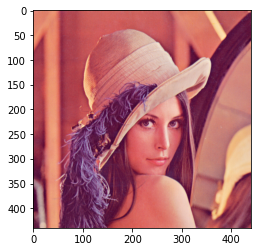

Brightness level


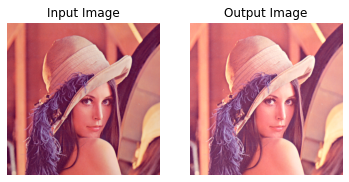

Contrast level


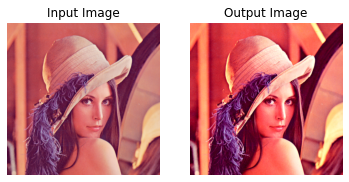

Flip


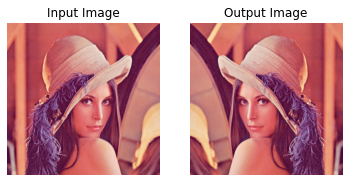

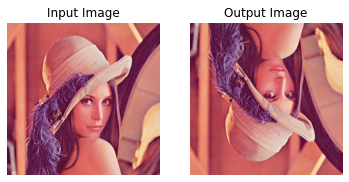

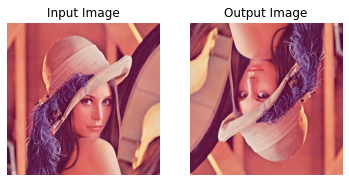

gray


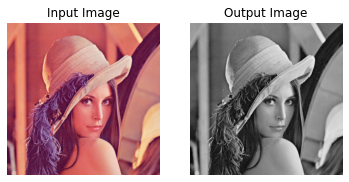

sepia


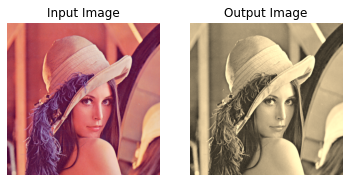

blur


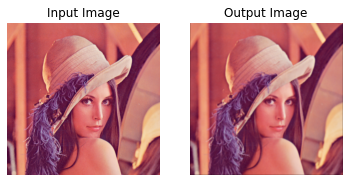

sharp


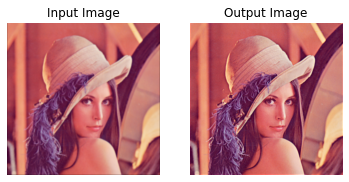

center_cut


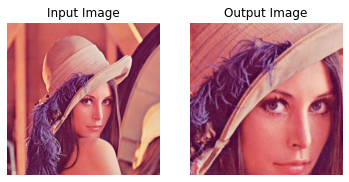

rounded_cut


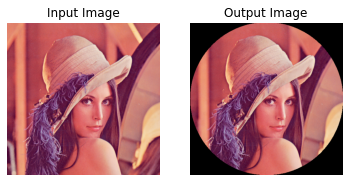

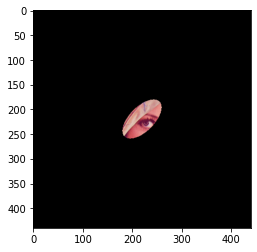

In [227]:
if __name__ == "__main__":
    main()